In [14]:
using Distributions
using Plots
using StatsPlots
using LinearAlgebra
using Random
using LaTeXStrings
using StatsBase
using StatsFuns
using CSV, DataFrames
using NPZ
using Healpix
using Zygote
using Zygote: @adjoint
using ChainRules.ChainRulesCore

In [15]:
include("utils.jl")

In [2]:
Random.seed!(1123)

TaskLocalRNG()

In [20]:
realiz_Dl = CSV.read("Capse_fiducial_Dl.csv", DataFrame)[1:lmax-1,1]
realiz_Cl = dl2cl(realiz_Dl, 2)
realiz_Cl[1] += 1e-10
realiz_Cl[2] += 1e-10

1.0e-10

In [5]:
function Cl2Kl(Cl)
    C̃ = Cl./1_500
    return norminvcdf.(0,1,C̃)
end

function Kl2Cl(Kl)
    return 1_500 .* normcdf.(0,1,Kl)
end

@adjoint function Kl2Cl(Kl)
    
    y = Kl2Cl(Kl)
    
    function Kl2Cl_PB(ȳ)
        x̄ = 1_500 .* pdf.(Normal(0,1), Kl) .* ȳ
        return (x̄,)
    end
    return y, Kl2Cl_PB
end     

In [6]:
nside=256
lmax=511

511

In [7]:
MCHMC_chain = npzread("MPI_chains/mask_MCHMC_nside_$(nside).npy")

262659×5000 Matrix{Float64}:
   1.37039        1.37039        1.37038     …    0.0145458    0.0219566
   7.68298        7.68297        7.68296         -0.0302457   -0.0161523
  -0.15788       -0.157879      -0.157879         0.0113641   -0.00570747
  -5.04363       -5.04363       -5.04362         -0.0130363   -0.0101789
 -10.904        -10.904        -10.904          -10.9433     -10.9322
 -16.6333       -16.6333       -16.6333      …  -16.6312     -16.6235
   1.26403        1.26403        1.26403          1.2593       1.27679
  -3.04634       -3.04634       -3.04634         -3.05322     -3.05758
  13.2382        13.2382        13.2382          13.2395      13.2348
  13.9589        13.9589        13.9589          13.9863      13.9881
 -20.6707       -20.6707       -20.6707      …  -20.6593     -20.6682
 -12.9462       -12.9462       -12.9462         -12.9578     -12.937
   4.60368        4.60368        4.60368          4.60003      4.6171
   ⋮                                         ⋱ 

In [16]:
MCHMC_alm = x_vec2vecmat(vec(mean(MCHMC_chain[1:end-lmax-4,:], dims=2)), lmax, 1)
MCHMC_map = alm2map(from_alm_to_healpix_alm(MCHMC_alm, lmax, 1)[1], nside);

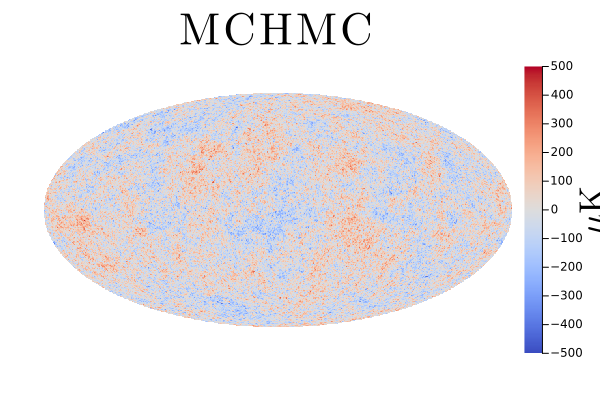

In [17]:
plot(MCHMC_map, color=:coolwarm, title=L"\mathrm{MCHMC}", colorbar_title=L"\mathrm{\mu K}", clim=(-500,500),
        titlefontsize=30, colorbar_titlefontsize=24, colorbar_tickfontsize=16)

In [18]:
MCHMC_Kl = vec(median(MCHMC_chain[end-lmax-3:end-3,:], dims=2))
MCHMC_σ_Kl = vec(std(MCHMC_chain[end-lmax-3:end-3,:], dims=2));

In [19]:
MCHMC_Cl = Kl2Cl(MCHMC_Kl)
MCHMC_σ_Cl = abs.(diag(jacobian(x->Kl2Cl(x), MCHMC_Kl)[1])).*MCHMC_σ_Kl;

In [22]:
dl_c = [l*(l+1)/2π for l in 0:lmax];

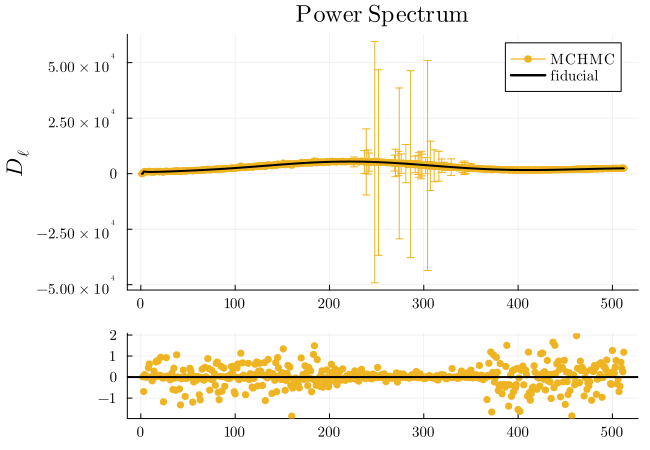

In [23]:
p = plot(layout=@layout([a;b{0.25h}]), plot_title=L"\mathrm{Power \ Spectrum}", xtickfontsize=10, ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, 
    legend_font_pointsize=10, titlefontsize=16, size=(650,450), xformatter=:latex, yformatter=:latex)
plot!(p, cl2dl(MCHMC_Cl,0), color="goldenrod2", label = L"\mathrm{MCHMC}", yerror=dl_c.*MCHMC_σ_Cl, markershape=:circle, markerstrokecolor="goldenrod2", subplot=1)
plot!(p, cl2dl(realiz_Cl,0), label = L"\mathrm{fiducial}", color="black", lw=2, ylabel=L"D_\ell", subplot=1, left_margin=2Plots.mm)

scatter!(p, (cl2dl(MCHMC_Cl,0).-(cl2dl(realiz_Cl,0)))./(dl_c.*MCHMC_σ_Cl), color="goldenrod2", label = "", markershape=:circle, markerstrokecolor="goldenrod2", subplot=2)
hline!([0], color="black", lw=2, subplot=2, label="")

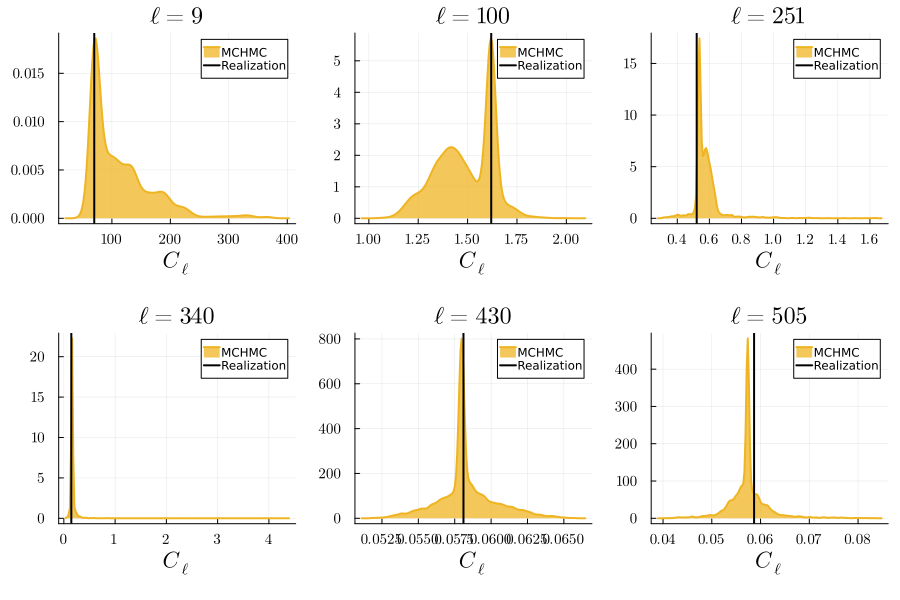

In [24]:
p = plot(layout=(2,3), size=(900,600),  xtickfontsize=10, ytickfontsize=10, xguidefontsize=15, yguidefontsize=15, 
    legend_font_pointsize=8, titlefontsize=16, xformatter=:latex, yformatter=:latex)

ℓs = [9, 100, 251, 340, 430, 505]

for i in 1:6

    density!(p, Kl2Cl(MCHMC_chain[end-lmax-4+ℓs[i],:]), color="goldenrod2", lw=2, fillrange=0, fillalpha=0.75, label="MCHMC", subplot=i)
    vline!(p, [realiz_Cl[ℓs[i]]], color="black", label="Realization", lw=2, title=L"\ell="*latexstring(ℓs[i]), xlabel=L"C_{\ell}", subplot=i, bottom_margin=7Plots.mm)
end
display(p)